In [ ]:
# Install relevant packages
!pip install pandas pytrends matplotlib plotly seaborn numpy panel

In [1]:
# Import libraries
from multiprocessing.dummy import Pool as ThreadPool
from datetime import date, timedelta, datetime
from pytrends.request import TrendReq   
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from functools import reduce
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import panel as pn

# Let user choose dates
pn.extension()
start_date_picker = pn.widgets.DatePicker(name='Choose start date')
end_date_picker = pn.widgets.DatePicker(name='Choose end date')
display(start_date_picker)
display(end_date_picker)

# Let user choose search term
pytrend = TrendReq()
search_term = input('Enter search term to investigate and press enter:\n').lower()

DatePicker(name='Choose start date')

DatePicker(name='Choose end date')

Enter search term to investigate and press enter:
loss of smell


In [2]:
# Set chosen dates
start_date = start_date_picker.value
end_date = end_date_picker.value

# Fetch data from Google trends
pytrend.build_payload(kw_list=[search_term], geo='US', timeframe=f'{start_date} {end_date}')
google_trends = pytrend.interest_by_region(resolution='Country', inc_low_vol=True, inc_geo_code=True).reset_index()
google_trends['code'] = google_trends['geoCode'].apply(lambda x: x.split('-')[1])

# Plot on map
map_color = 'YlOrRd'
fig = px.choropleth(google_trends,
                    locations="code",
                    color=search_term,
                    hover_name="geoName",
                    color_continuous_scale=map_color,
                    locationmode = 'USA-states')

fig.update_coloraxes(cmid=50)
fig.update_layout(title_text = f'Heatmap for search terms: {search_term}', geo_scope='usa')
fig.show()

In [3]:
# Get latest data CSV file (one day back is most up to date)
yesterday = (date.today() - timedelta(days=1)).strftime("%m-%d-%Y")

# Create heatmap of normalized death ratio per state
covid_data = pd.read_csv(f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/{yesterday}.csv')
covid_data = covid_data.join(google_trends.set_index('geoName'), on='Province_State', how='left')

population = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

covid_data = covid_data.join(population.groupby(['Province_State']).sum()[['Population']], on='Province_State')
covid_data['DeathRatio'] = (covid_data['Deaths'] / covid_data['Population'])

fig = px.choropleth(covid_data,
                    locations="code",
                    color="DeathRatio",
                    hover_name="Province_State",
                    color_continuous_scale=map_color,
                    locationmode = 'USA-states')

fig.update_coloraxes(cmin=0)
fig.update_layout(title_text = 'Covid normalized deaths per state heatmap', geo_scope='usa')
fig.show()

In [4]:
# Build country name to country code mapping (using a dummy query which is a bit hacky, but does the job)
pytrend = TrendReq()
pytrend.build_payload(kw_list=['covid'], geo='US', timeframe='2021-1-1 2022-1-1')
country_map = pytrend.interest_by_region(resolution='Country', inc_low_vol=True, inc_geo_code=True)
country_map = country_map.reset_index()[['geoName', 'geoCode']]

# Get Google trends data per state using a thread pool to speed up the process
def get_trend(state):
    pytrend = TrendReq()
    
    pytrend.build_payload(kw_list=[search_term], geo=state, timeframe=f'{start_date} {end_date}')

    result = pytrend.interest_over_time()
    result['geoCode'] = state
    result['keyword'] = search_term
    
    print(f'finished looking for \'{search_term}\' trend at \'{state}\'', end='\x1b[1K\r')
    return result.reset_index().rename(columns={search_term: 'value'})

pool = ThreadPool(3) # Increasing this number will increase speed but might get you blocked by Google servers
dfs = pool.map(get_trend, country_map['geoCode'].unique())

# Merge results and join with country mapping        
google_trends = pd.concat(dfs).sort_values(['date'])
google_trends = google_trends.join(country_map.set_index('geoCode'), on='geoCode', how='left')

display(google_trends.head())

date  value isPartial geoCode        keyword        geoName
0 2020-01-05      0     False   US-AL  loss of smell        Alabama
0 2020-01-05      0     False   US-MA  loss of smell  Massachusetts
0 2020-01-05      0     False   US-WI  loss of smell      Wisconsin
0 2020-01-05      0     False   US-KY  loss of smell       Kentucky
0 2020-01-05      0     False   US-ND  loss of smell   North Dakota

In [5]:
# Disable chained assignment warning in Pandas
pd.options.mode.chained_assignment = None

# Get Covid deaths time series
covid_raw_series = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

# Get Covid vaccination time series
vaccination_raw_series = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')
vaccination_series = vaccination_raw_series[['location', 'date', 'daily_vaccinations']]
vaccination_series['Date'] = vaccination_series['date'].astype('datetime64')

# Melt date columns into a single date column
covid_series = covid_raw_series.groupby(['Province_State']).sum().reset_index()
covid_series = covid_series.melt(id_vars=['Province_State'], value_vars=list(covid_series.columns[7:])).rename(columns={'variable': 'Date', 'value': 'Deaths'},)   
covid_series['Date'] = covid_series['Date'].astype('datetime64')

# Enrich & normalize data
covid_series = covid_series.join(covid_raw_series.groupby(['Province_State']).sum()[['Population']], on='Province_State')
covid_series['DeathRatio'] = (covid_series['Deaths'] / covid_series['Population']) * 100

# Filter relevant dates
vaccination_series = vaccination_series[(vaccination_series['Date'] >= np.datetime64(start_date)) & (vaccination_series['Date'] <= np.datetime64(end_date))]
covid_series = covid_series[(covid_series['Date'] >= np.datetime64(start_date)) & (covid_series['Date'] <= np.datetime64(end_date))]

# Bucket dates by weeks (since google trends data is bucketed that way and we want a date-to-date match)
covid_series = covid_series.sort_values(['Province_State', 'Date'])
covid_series['Date'] = pd.to_datetime(covid_series['Date']) - pd.to_timedelta(7, unit='d')
covid_series = covid_series.groupby(['Province_State', pd.Grouper(key='Date', freq='W-SUN')])['Deaths'].sum().reset_index().sort_values('Date')

vaccination_series = vaccination_series.sort_values(['location', 'date'])
vaccination_series['date'] = pd.to_datetime(vaccination_series['date']) - pd.to_timedelta(7, unit='d')
vaccination_series = vaccination_series.groupby(['location', pd.Grouper(key='date', freq='W-SUN')])['daily_vaccinations'].sum().reset_index().sort_values('date')
vaccination_series = vaccination_series.rename(columns={'location': 'Province_State', 'date': 'Date', 'daily_vaccinations': 'VaccinationsOnDate'})

# Manually fix state naming conventions so they will match between dataframes
vaccination_series['Province_State'] = vaccination_series['Province_State'].replace("New York State", "New York")

display(covid_series.head())
display(vaccination_series.head())

Province_State       Date  Deaths
0           Alabama 2020-01-19       0
570        Colorado 2020-01-19       0
2470       Michigan 2020-01-19       0
3325     New Mexico 2020-01-19       0
5320      Wisconsin 2020-01-19       0

Province_State       Date  VaccinationsOnDate
2383      United States 2020-12-13                 0.0
2384      United States 2020-12-20           1184961.0
2385      United States 2020-12-27           1950991.0
2386      United States 2021-01-03           2852361.0
2120  Republic of Palau 2021-01-10              1163.0

In [6]:
# Create dataframe per state
state_dfs = []

for state in covid_series['Province_State'].unique():
    state_df = covid_series[covid_series['Province_State'] == state]    
    vaccine_df = vaccination_series[vaccination_series['Province_State'] == state]
    
    # Calculate diff from the acummulative raw data
    state_df['DeathsOnDate'] = state_df['Deaths'].diff()
    
    # Normalize values on scale of 0-100 to match Google trends data
    state_df['NDeaths'] = 100 * state_df['DeathsOnDate'] / state_df['DeathsOnDate'].max()    
    vaccine_df['NVaccinated'] = 100 * vaccine_df['VaccinationsOnDate'] / vaccine_df['VaccinationsOnDate'].max()
    
    # Join death & vaccination data with google trends data
    state_df = state_df[state_df['DeathsOnDate'] >= 0]  
    state_df = state_df.join(google_trends[google_trends['geoName'] == state].set_index('date'), on='Date', how='left')        
    state_df = state_df.merge(vaccine_df.set_index('Date'), on='Date', how='left')
    state_df = state_df.rename(columns={'Province_State_x': 'Province_State', 'keyword': 'Keyword', 'value': 'Value'})
    
    # Smoothen google trends data with a rolling mean
    state_df['RollingMean'] = state_df['Value'].rolling(window=3).mean()
    state_df['RollingMean'] = 100 * state_df['RollingMean'] / state_df['RollingMean'].max()
    
    state_dfs.append(state_df[['Province_State', 'Date', 'Keyword', 'RollingMean', 'Value', 'NDeaths', 'NVaccinated']])
    
print(f'Successfully created {len(state_dfs)} dataframes')

display(state_dfs[0].head())

Successfully created 58 dataframes


Province_State       Date        Keyword  RollingMean  Value  NDeaths  \
0        Alabama 2020-01-26  loss of smell          NaN      0      0.0   
1        Alabama 2020-02-02  loss of smell          NaN     13      0.0   
2        Alabama 2020-02-09  loss of smell     4.887218      0      0.0   
3        Alabama 2020-02-16  loss of smell     4.887218      0      0.0   
4        Alabama 2020-02-23  loss of smell     0.000000      0      0.0   

   NVaccinated  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

Timeline plot - Alabama:


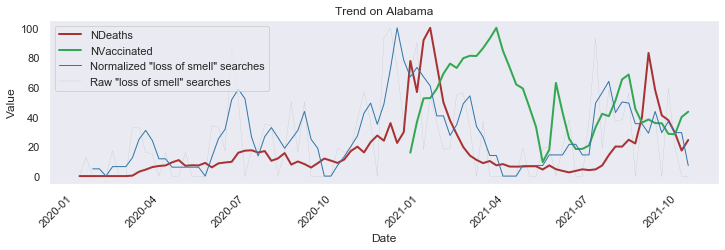

Timeline plot - Colorado:


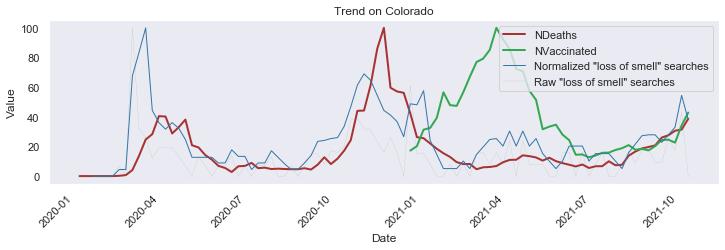

Timeline plot - Michigan:


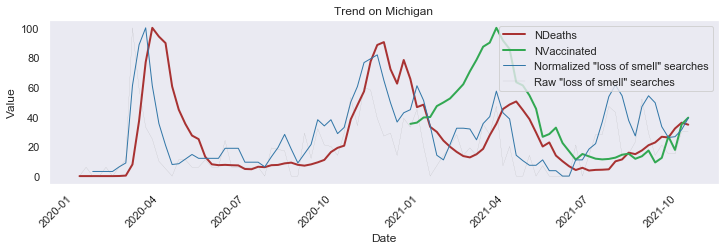

Timeline plot - New Mexico:


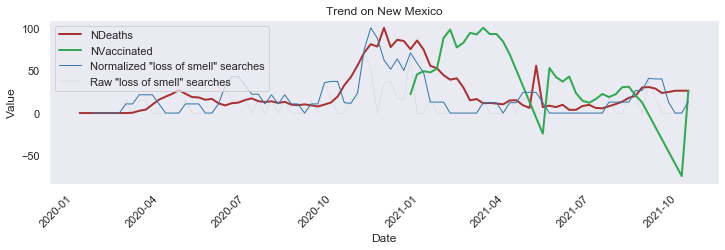

Timeline plot - Wisconsin:


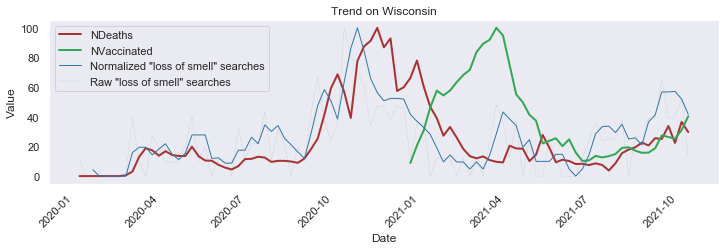

Timeline plot - Tennessee:


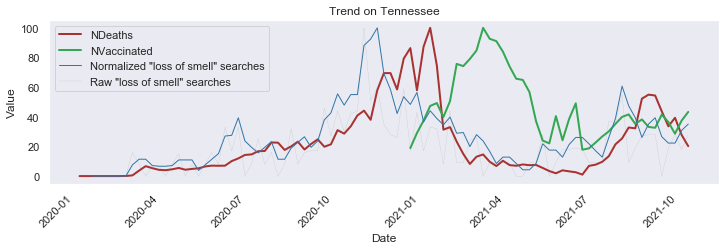

Timeline plot - South Dakota:


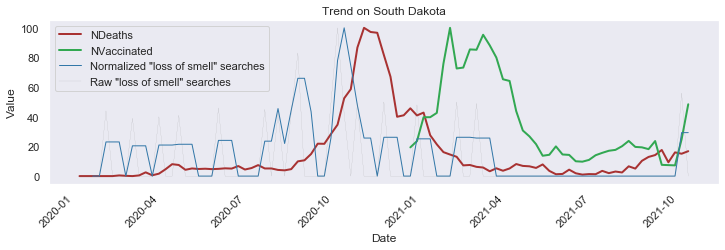

Timeline plot - Massachusetts:


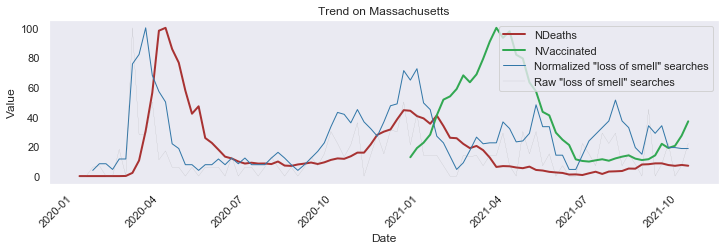

Timeline plot - Kentucky:


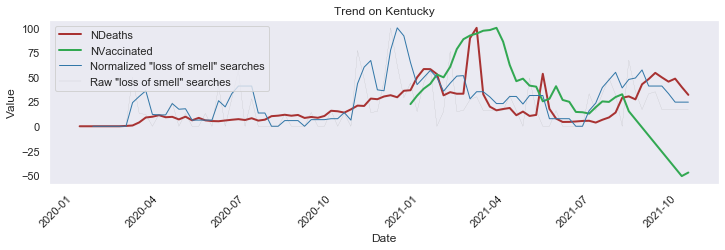

Timeline plot - Guam:


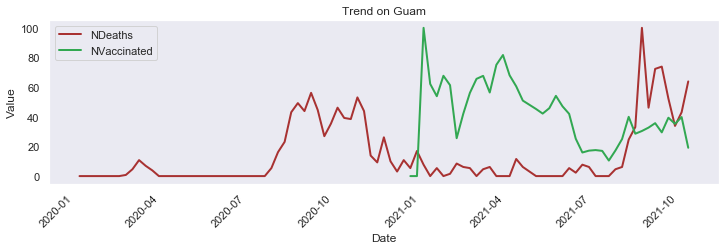

Timeline plot - Hawaii:


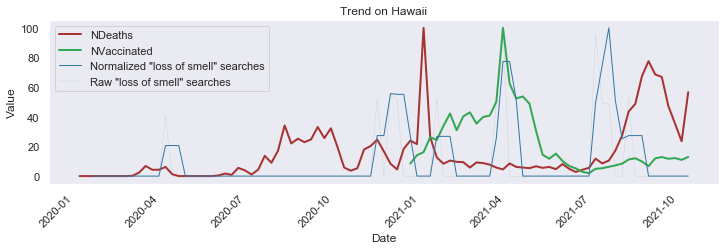

Timeline plot - New York:


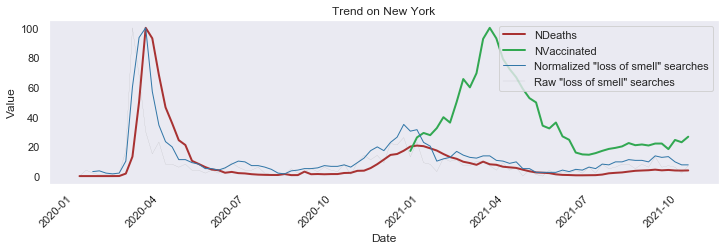

Timeline plot - North Carolina:


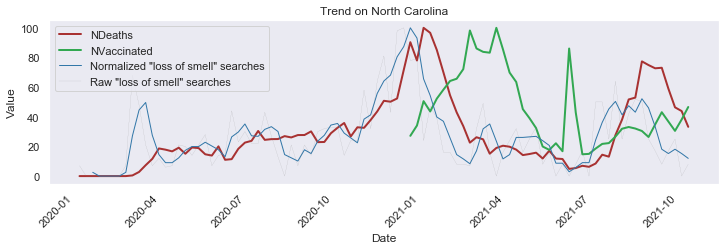

Timeline plot - Alaska:


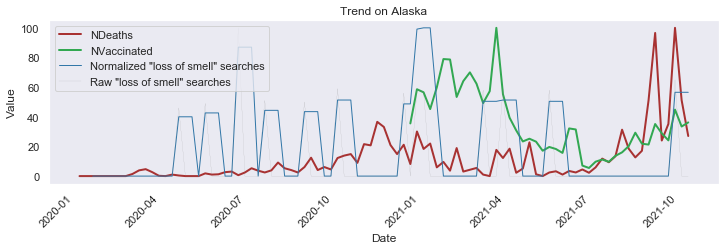

Timeline plot - South Carolina:


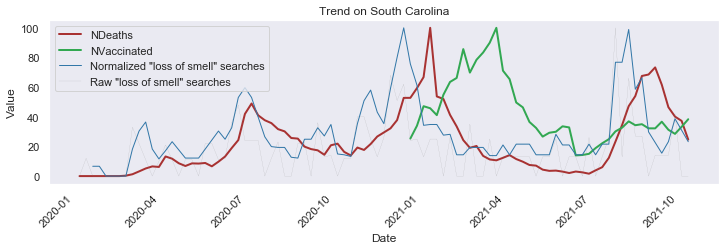

Timeline plot - Grand Princess:


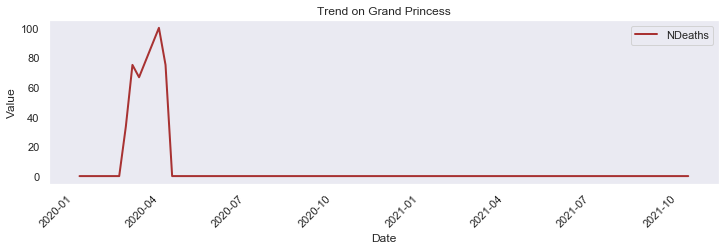

Timeline plot - North Dakota:


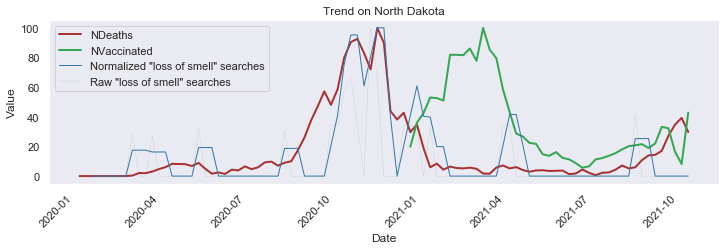

Timeline plot - Delaware:


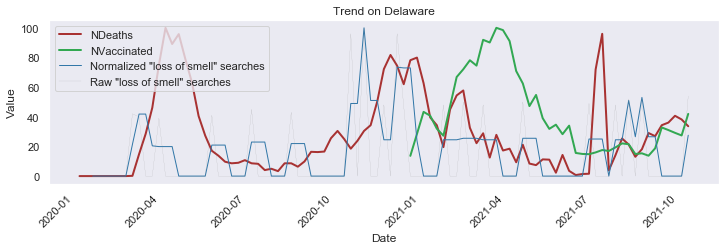

Timeline plot - Wyoming:


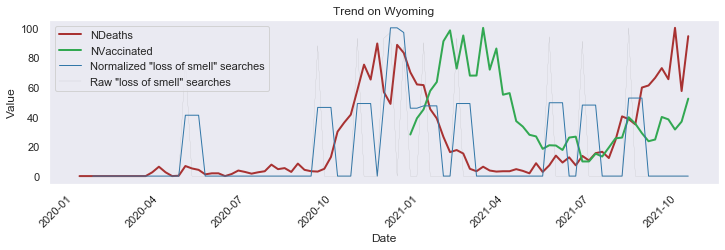

Timeline plot - Rhode Island:


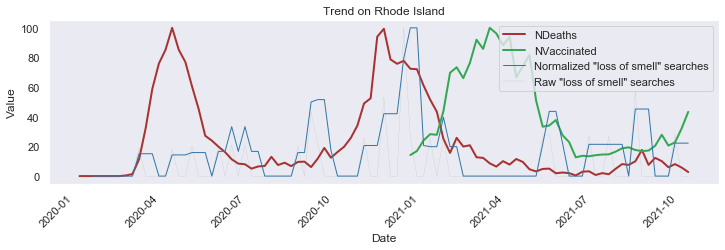

Timeline plot - Georgia:


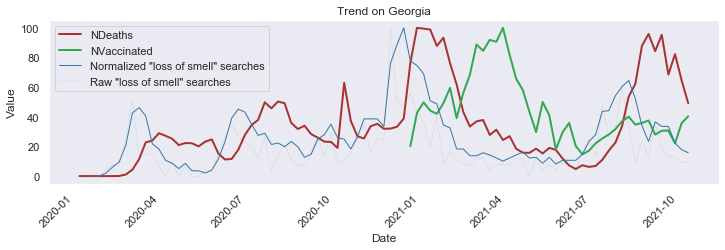

Timeline plot - Connecticut:


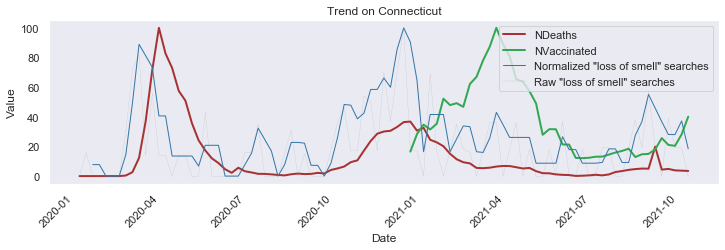

Timeline plot - Northern Mariana Islands:


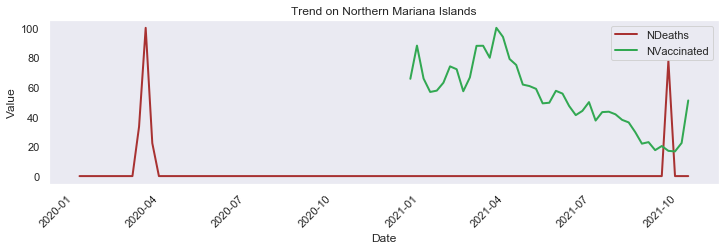

Timeline plot - Texas:


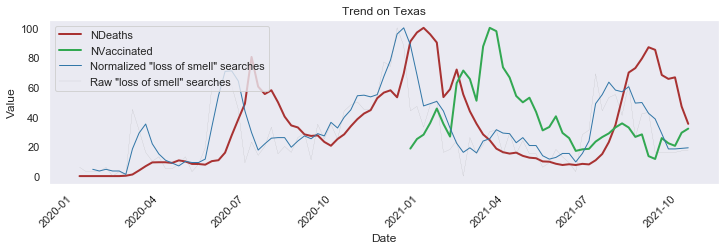

Timeline plot - New Hampshire:


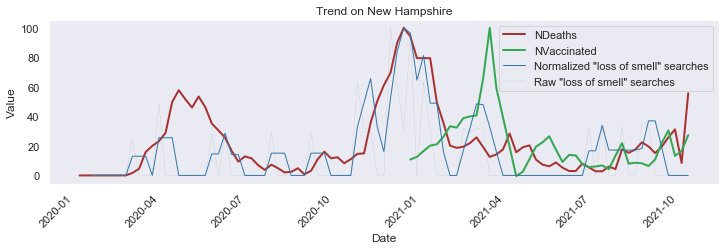

Timeline plot - Mississippi:


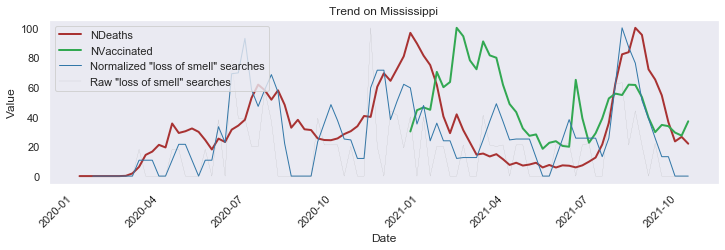

Timeline plot - Iowa:


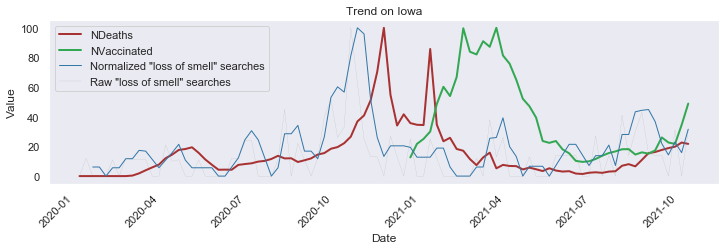

Timeline plot - Missouri:


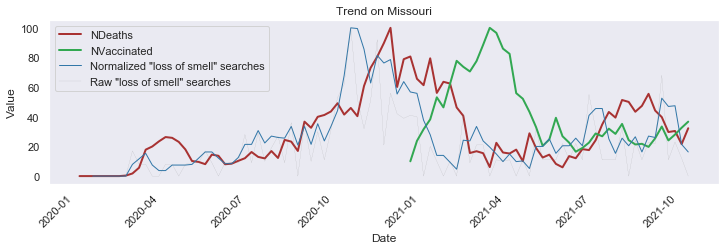

Timeline plot - Washington:


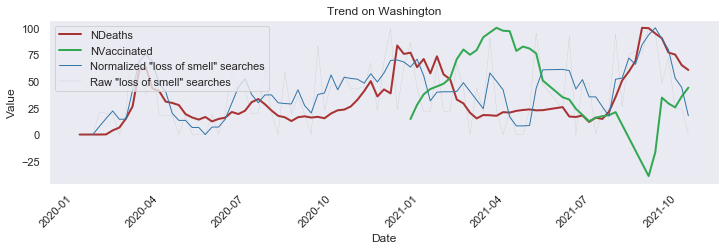

Timeline plot - Virginia:


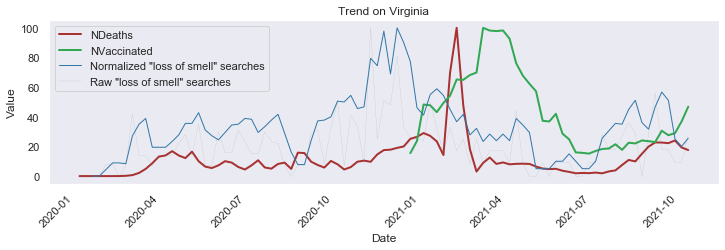

Timeline plot - Indiana:


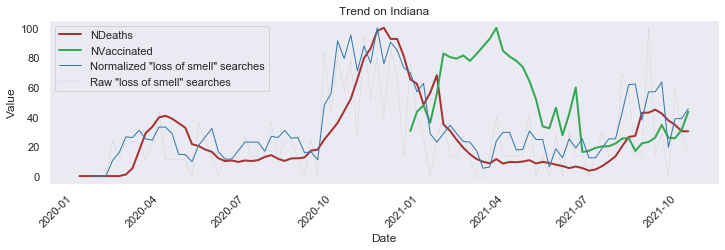

Timeline plot - Virgin Islands:


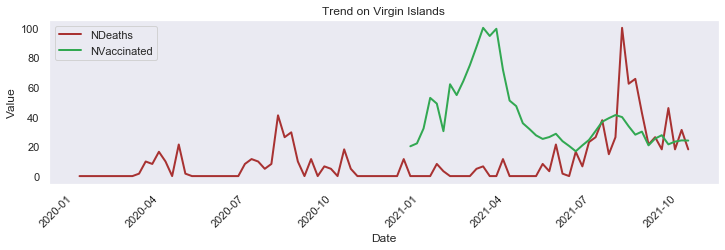

Timeline plot - Montana:


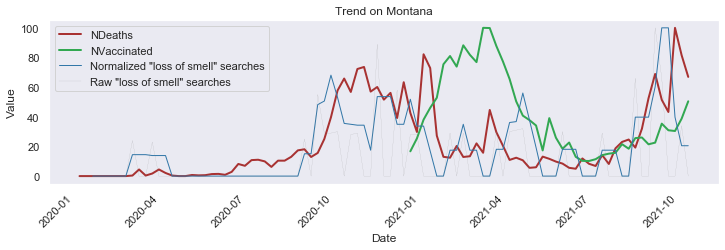

Timeline plot - Arkansas:


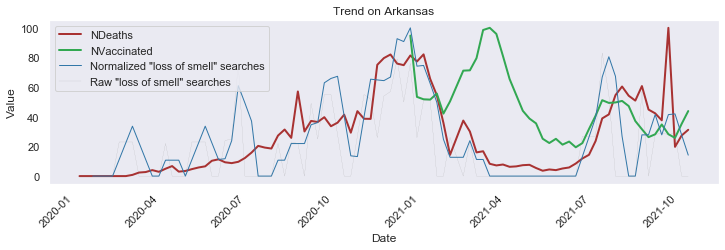

Timeline plot - New Jersey:


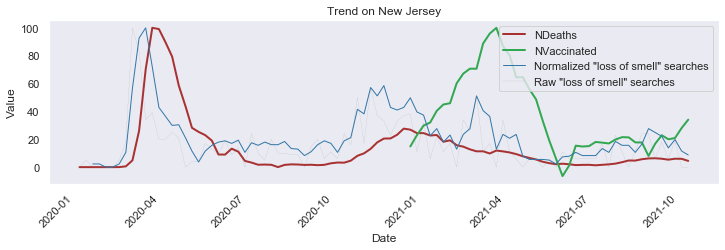

Timeline plot - Illinois:


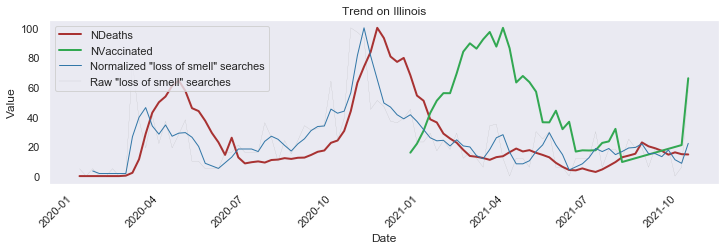

Timeline plot - Minnesota:


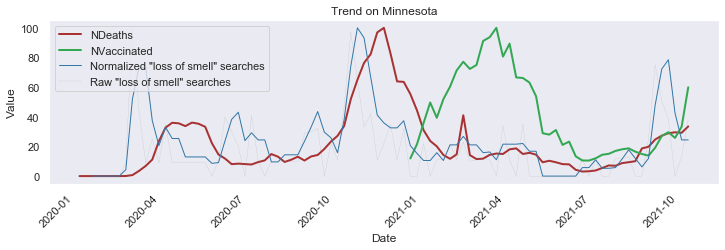

Timeline plot - Vermont:


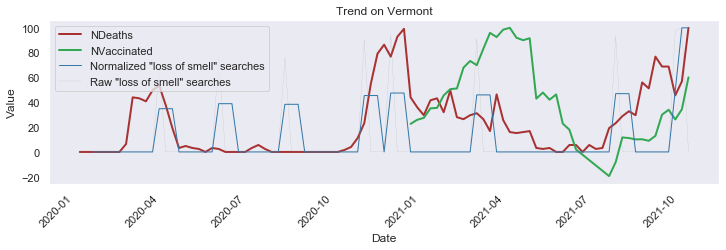

Timeline plot - Nevada:


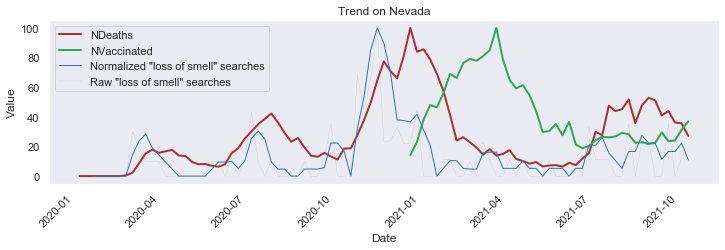

Timeline plot - Utah:


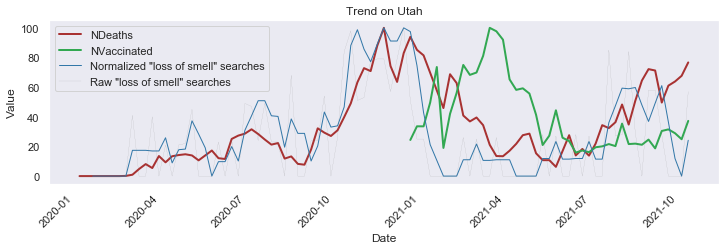

Timeline plot - California:


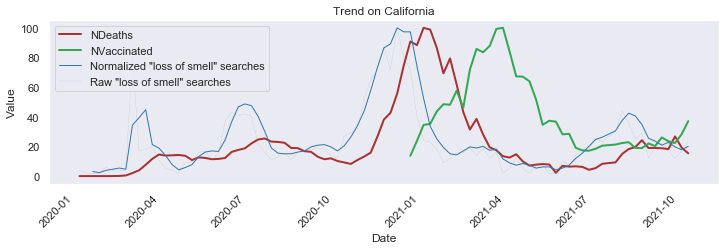

Timeline plot - American Samoa:


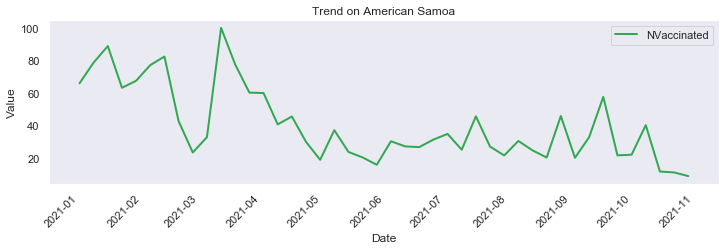

Timeline plot - Kansas:


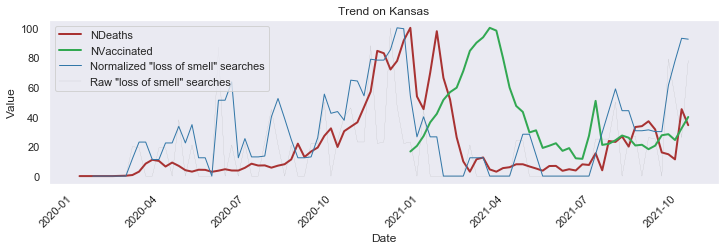

Timeline plot - West Virginia:


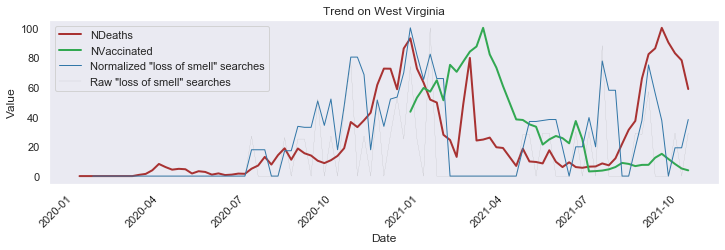

Timeline plot - Idaho:


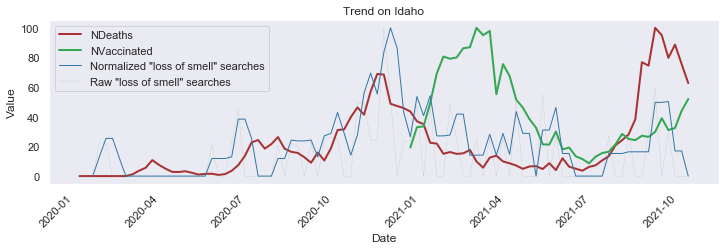

Timeline plot - Nebraska:


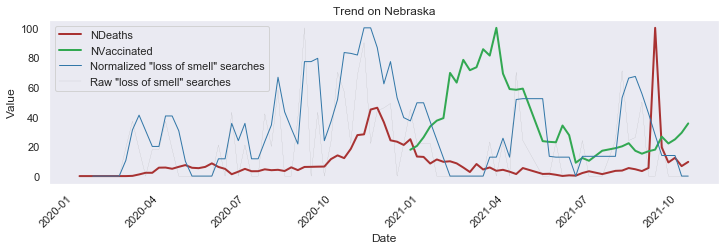

Timeline plot - Maryland:


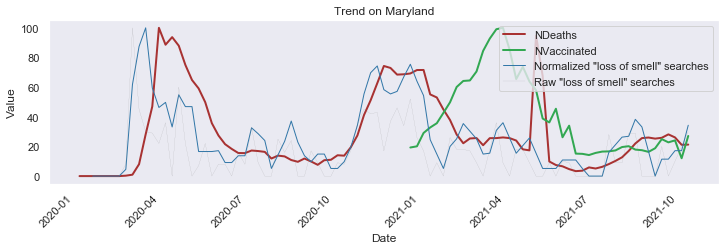

Timeline plot - Arizona:


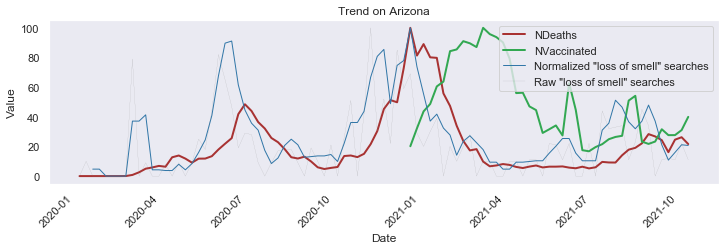

Timeline plot - Oregon:


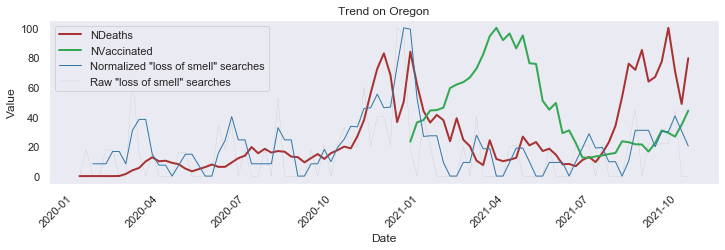

Timeline plot - Diamond Princess:


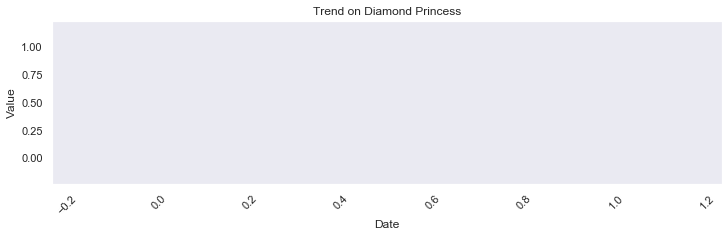

Timeline plot - Ohio:


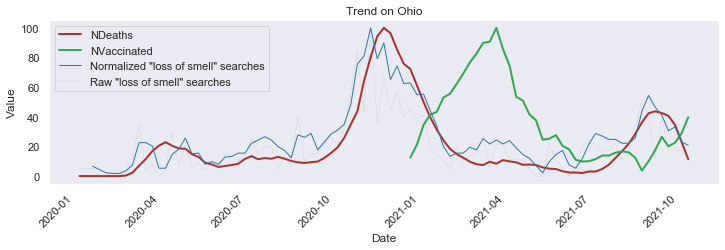

Timeline plot - Maine:


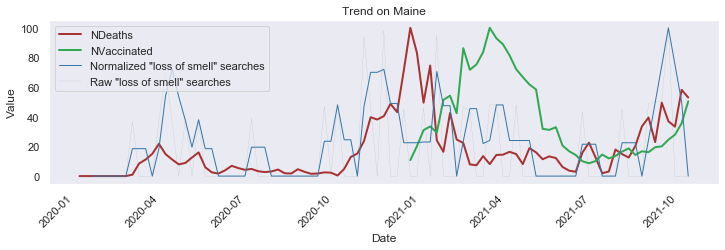

Timeline plot - Louisiana:


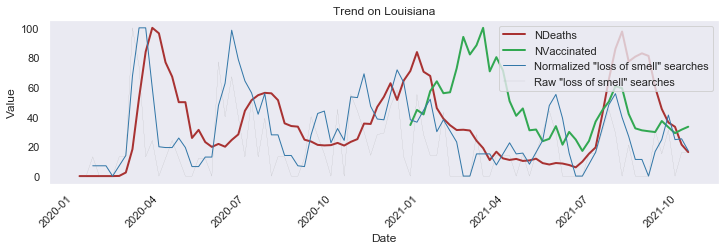

Timeline plot - Oklahoma:


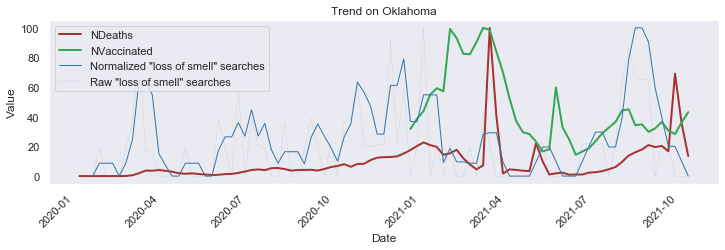

Timeline plot - Pennsylvania:


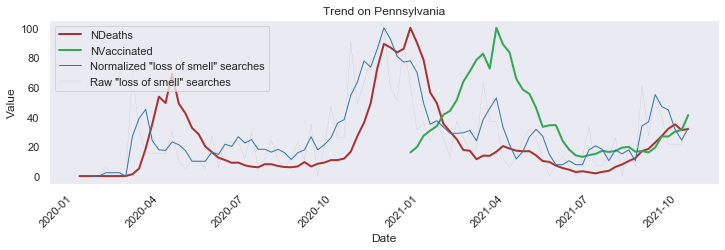

Timeline plot - Puerto Rico:


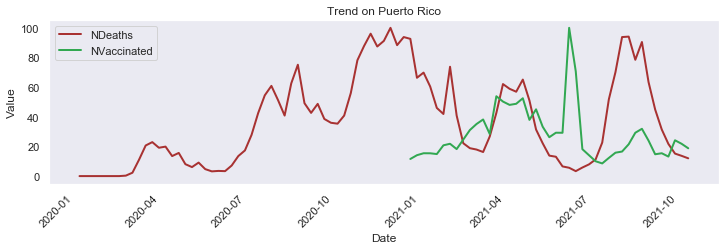

Timeline plot - Florida:


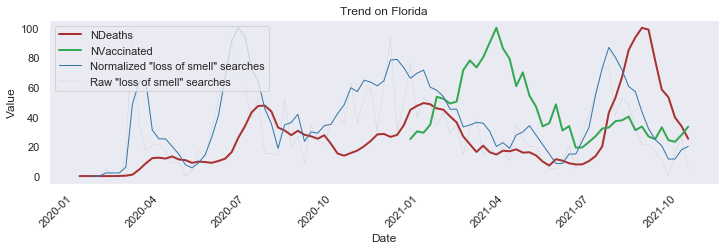

Timeline plot - District of Columbia:


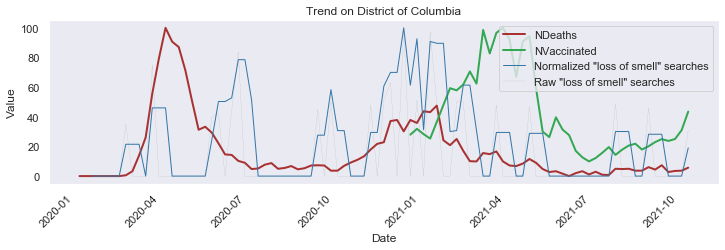

In [7]:
# Plot timecharts
for state_df in state_dfs:
    
    # Plot search ranking vs. death rate
    state = state_df["Province_State"].iloc[0]    
    print(f'Timeline plot - {state}:')
    
    sns.set(rc={'figure.figsize':(12,3)})
    
    line_width = 2
    sns.lineplot(x="Date", y="NDeaths", data=state_df, color="#a83232", linewidth = line_width, label='NDeaths').grid(False)
    sns.lineplot(x="Date", y="NVaccinated", data=state_df, color="#32a852", linewidth = line_width, label='NVaccinated').grid(False)
    sns.lineplot(x="Date", y="RollingMean", data=state_df,  color="#3277a8", linewidth = 1, label=f'Normalized "{search_term}" searches').grid(False)
    sns.lineplot(x="Date", y="Value", data=state_df,  color="grey", linewidth = 0.1, label=f'Raw "{search_term}" searches').grid(False)
    
    plt.xticks(rotation=45)
    plt.title(f'Trend on {state}')
    plt.show()

In [8]:
# Plot correlation matrices

spearman_deaths = {}
spearman_vaccinations = {}

for state_df in state_dfs:
    state = state_df["Province_State"].iloc[0]
    
    # Calculate Spearman correlation
    expanded_df = state_df.groupby(['Province_State', 'Date', 'NDeaths', 'NVaccinated', 'Keyword'])['RollingMean'].aggregate('first').unstack().reset_index()
    
    try:
        corr = expanded_df[['NDeaths', 'NVaccinated'] + [search_term]].corr(method='spearman')
    except Exception as e:
        print(f'Could not process data for state: {state}, error: {e}')
    
    matrix = np.triu(corr)
    spearman_deaths[state] = corr['NDeaths'][search_term] 
    spearman_vaccinations[state] = corr['NVaccinated'][search_term]
          
country_map['spearman_death'] = country_map['geoName'].apply(lambda x: spearman_deaths[x] if x in spearman_deaths else None)       
country_map['spearman_vaccinated'] = country_map['geoName'].apply(lambda x: spearman_vaccinations[x] if x in spearman_vaccinations else None) 
country_map['code'] = country_map['geoCode'].apply(lambda x: x.split('-')[1])
    
# Plot spearman correlation of search terms with with death trend
fig = px.choropleth(country_map,
                    locations="code",
                    color="spearman_death",
                    hover_name="geoName",
                    color_continuous_scale='rdbu_r',
                    locationmode = 'USA-states')

fig.update_coloraxes(cmid=0)
fig.update_layout(title_text = f'Spearman correlations between search term "{search_term}" and death rate', geo_scope='usa')
fig.show()

# Plot spearman correlation of search terms with with vaccination trend
fig = px.choropleth(country_map,
                    locations="code",
                    color="spearman_vaccinated",
                    hover_name="geoName",
                    color_continuous_scale='rdbu_r',
                    locationmode = 'USA-states')

fig.update_coloraxes(cmid=0)
fig.update_layout(title_text = f'Spearman correlations between search term "{search_term}" and vaccination rate', geo_scope='usa')
fig.show()

Could not process data for state: Guam, error: "['loss of smell'] not in index"
Could not process data for state: Grand Princess, error: "['loss of smell'] not in index"
Could not process data for state: Northern Mariana Islands, error: "['loss of smell'] not in index"
Could not process data for state: Virgin Islands, error: "['loss of smell'] not in index"
Could not process data for state: American Samoa, error: "['loss of smell'] not in index"
Could not process data for state: Diamond Princess, error: "['loss of smell'] not in index"
Could not process data for state: Puerto Rico, error: "['loss of smell'] not in index"
